## SETUP

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import load_model
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
import pandas as pd

import imageio
from tensorflow_docs.vis import embed

## PARAMETERS

In [2]:
image_size = 256
generator_input = 16
batch_size = 16
folder = 'BasicGAN_gen/9000img/6.1.2 basic gan maxpool/setting 6/'

## IMPORT

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
   "images_proc", label_mode=None, image_size=(image_size, image_size), batch_size=batch_size, crop_to_aspect_ratio=True
)
dataset = dataset.map(lambda x: x / 255.0)

Found 9132 files belonging to 1 classes.


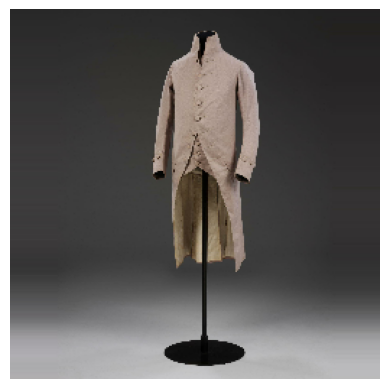

In [46]:
# display one image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## DISCRIMINATOR

In [4]:
discriminator = keras.Sequential(
    [   
        # use maxpool instead of conv2d at the first two downsize

        keras.Input(shape=(image_size, image_size, 3)),

        layers.Conv2D(128, kernel_size=5, strides=1, padding="same"),
        layers.MaxPool2D(pool_size=(5,5), strides=2, padding="same"),

        layers.Conv2D(256, kernel_size=3, strides=1, padding="same"),
        layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same"),

        layers.Conv2D(256, kernel_size=3, strides=1, padding="same"),
        layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same"),

        layers.Conv2D(512, kernel_size=3, strides=1, padding="same"),
        layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same"),

        layers.Flatten(),
        # layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 256)     295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       590080    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 256)    

## GENERATOR

In [1]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(generator_input * generator_input * 128),
        layers.Reshape((generator_input, generator_input, 128)),
        # layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding="same"),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # layers.Conv2DTranspose(256, kernel_size=3, strides=1, padding="same"),
        layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=3, strides=1, padding="same"),
        layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # layers.Conv2DTranspose(512, kernel_size=5, strides=1, padding="same"),
        layers.Conv2DTranspose(512, kernel_size=5, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

NameError: name 'keras' is not defined

## GAN

In [11]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## GAN monitor

In [12]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"{folder}generated_img_%03d_%d.png" % (epoch, i))

## FIT

In [13]:
learning_rate = 0.0001

In [14]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

In [15]:
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


In [151]:
# gan.load_weights(filepath=f'{folder}GAN_maxpool_9000_4_10ep')

In [16]:
epochs = 30  # In practice, use ~100 epochs

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

Epoch 1/30
571/571 [==============================] - 764s 1s/step - d_loss: 0.4179 - g_loss: 3.0397
Epoch 2/30
571/571 [==============================] - 751s 1s/step - d_loss: 0.4198 - g_loss: 3.1850
Epoch 3/30
571/571 [==============================] - 748s 1s/step - d_loss: 0.2520 - g_loss: 5.6233
Epoch 4/30
571/571 [==============================] - 737s 1s/step - d_loss: 0.0027 - g_loss: 19.2228
Epoch 5/30
571/571 [==============================] - 739s 1s/step - d_loss: 3.0950 - g_loss: 155.3884
Epoch 6/30
571/571 [==============================] - 744s 1s/step - d_loss: 0.1151 - g_loss: 13.8186
Epoch 7/30
571/571 [==============================] - 748s 1s/step - d_loss: 0.2338 - g_loss: 4.5749
Epoch 8/30
571/571 [==============================] - 752s 1s/step - d_loss: 0.2319 - g_loss: 3.8798
Epoch 9/30
571/571 [==============================] - 755s 1s/step - d_loss: 0.2430 - g_loss: 4.3949
Epoch 10/30
571/571 [==============================] - 753s 1s/step - d_loss: 0.2527 - 

## plot and save

In [17]:
# # uncomment to initiate a dataframe to hold dloss and gloss
dg_df = pd.DataFrame(columns=['d_loss','g_loss'])
# dg_df = pd.read_csv('BasicGAN_gen/9000img/6.1.2 basic gan maxpool/setting3/dgloss.csv')

In [18]:
d_loss = gan.history.history['d_loss']
g_loss = gan.history.history['g_loss']
epch = range(1,len(d_loss)+1)

In [19]:
dg_list = list(zip(d_loss,g_loss))
dg_df_new = pd.DataFrame(dg_list,columns=['d_loss','g_loss'])
dg_df = pd.concat([dg_df,dg_df_new],axis=0)

In [20]:
dg_df.reset_index(drop=True)

,d_loss,g_loss
0,0.417911,3.039716
1,0.419836,3.184956
2,0.252021,5.623257
3,0.002689,19.222837
4,3.094980,155.388443
5,0.115075,13.818563
6,0.233761,4.574867
7,0.231948,3.879823
8,0.243007,4.394861
9,0.252677,7.169396


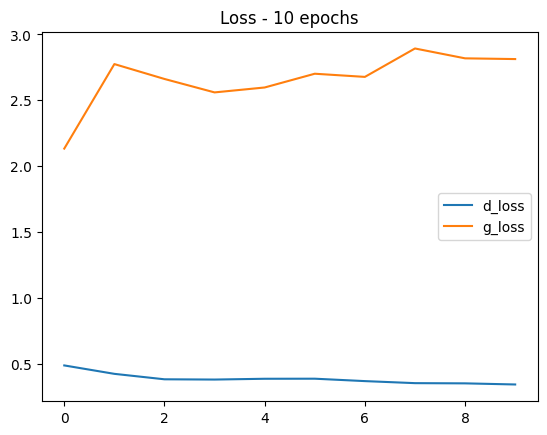

In [110]:
dg_df.reset_index(drop=True).plot()
plt.title(f"Loss - {dg_df.shape[0]} epochs")
plt.legend();

In [21]:
dg_df.to_csv(f'{folder}dgloss.csv',index=False)

In [22]:
gan.save_weights(filepath=f'{folder}GAN_maxpool_9000_4_30ep')

## generate


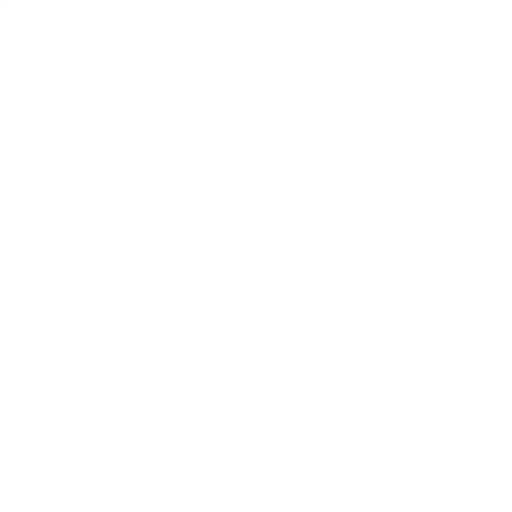

In [23]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 1  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))
noise_and_labels = tf.concat([interpolation_noise], 1)
fake = trained_gen.predict(noise_and_labels)

counter = 1
file_name = f"result {counter}.gif"
filepath = folder + file_name

fake *= 255.0
converted_images = fake.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (512, 512)).numpy().astype(np.uint8)
imageio.mimsave(filepath, converted_images, fps=0.5)
embed.embed_file(filepath)

## visualization

### sample image

In [24]:
from tensorflow.keras.preprocessing import image

(1, 256, 256, 3)


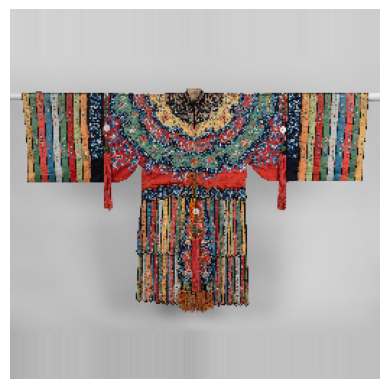

In [25]:
img_path = 'images_proc/full_selection_sel/70503.jpg'

img = image.load_img(img_path, target_size=(256, 256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.axis("off")
plt.show();

### discriminator visualization

- one layer

In [26]:
from keras import models

In [27]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in gan.discriminator.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=gan.discriminator.input, outputs=layer_outputs)

(1, 256, 256, 128)


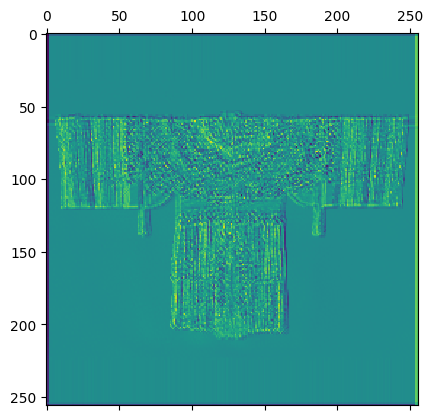

In [28]:
# Returns an array for each activation layer
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the *third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis') 
plt.show()

- multiple layers

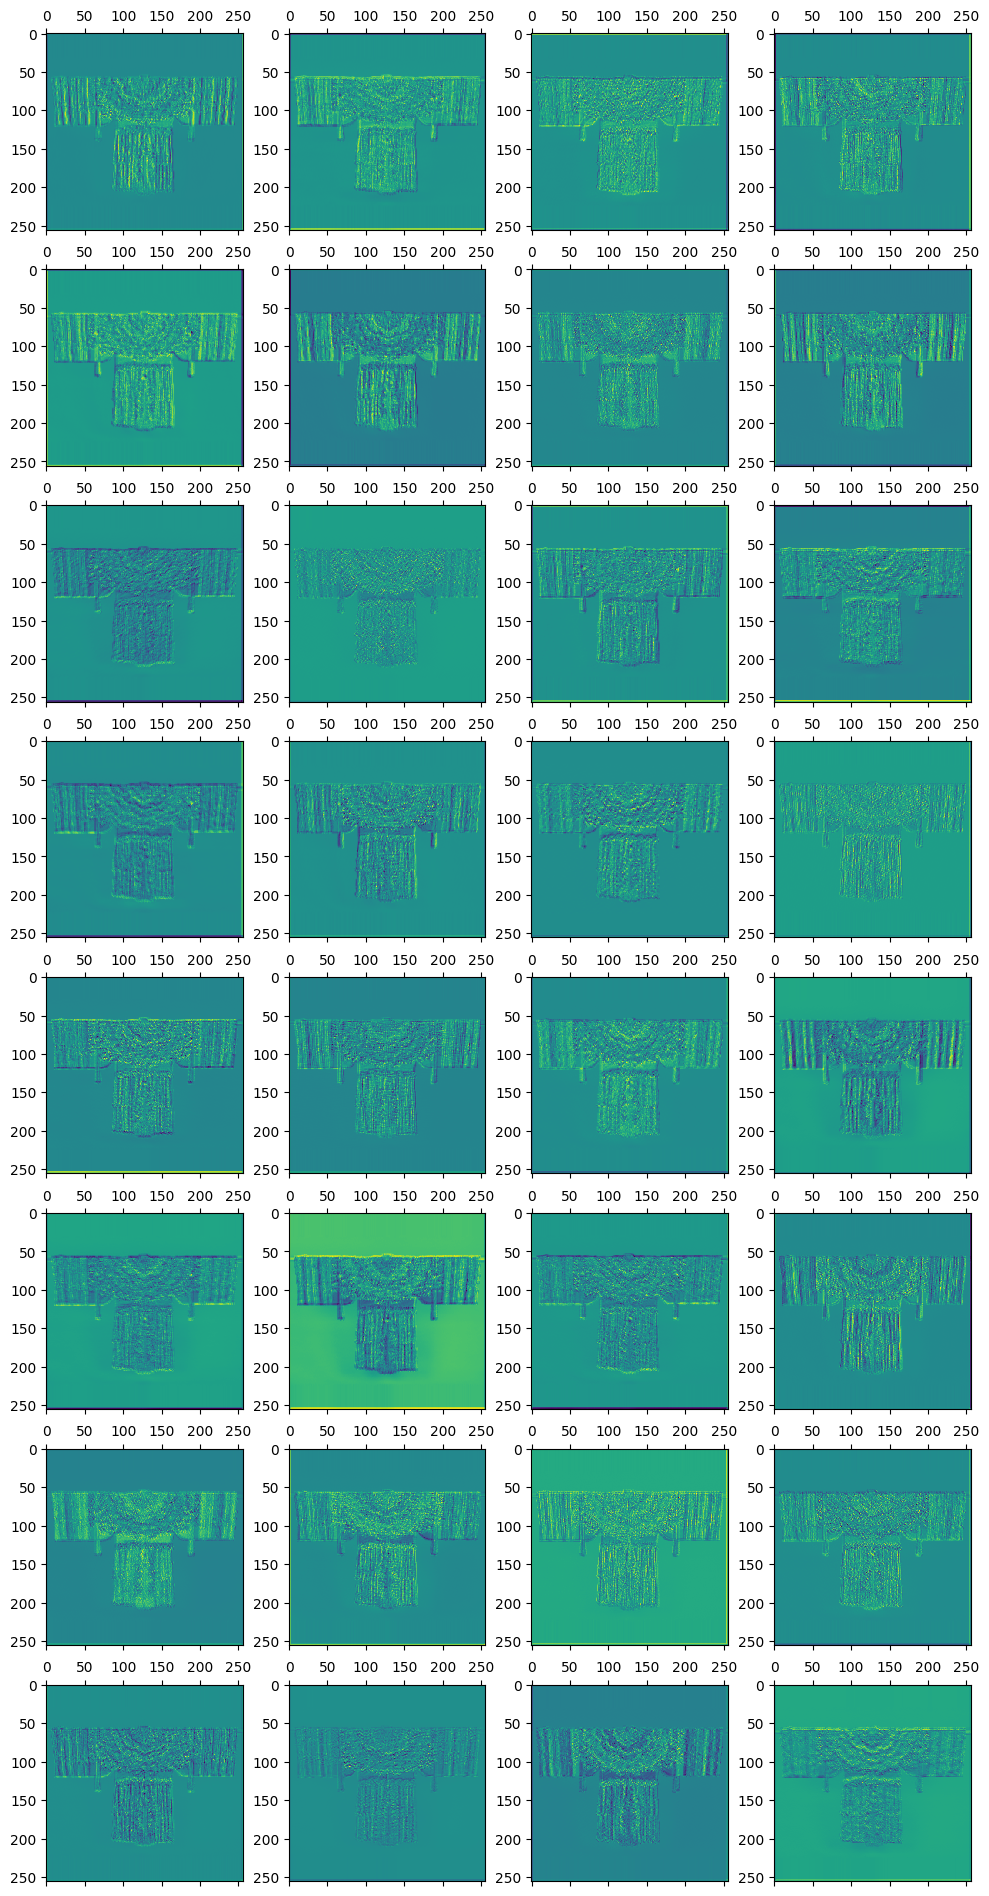

In [29]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

- all activations, at 12th channel

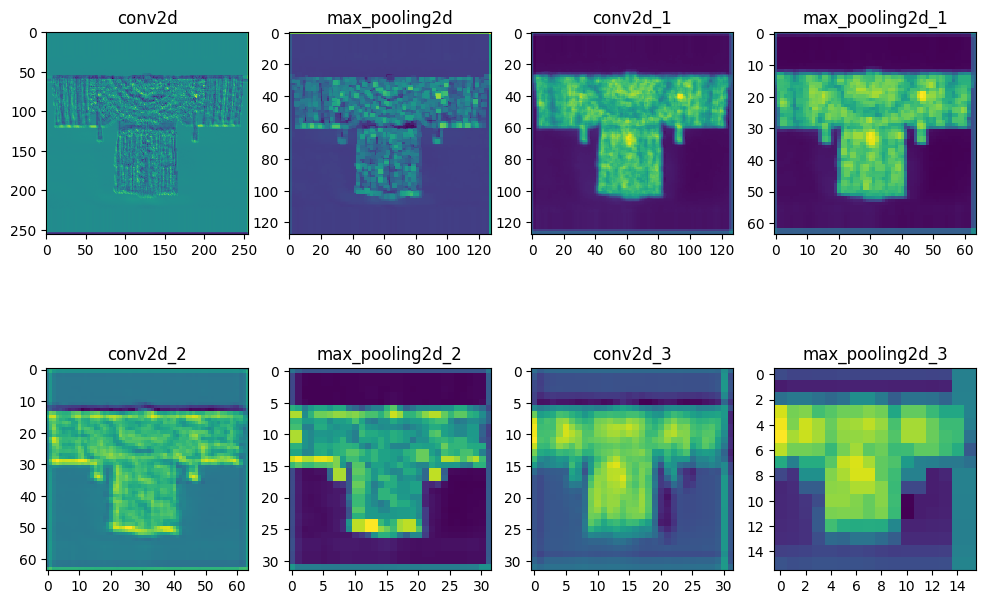

In [30]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in gan.discriminator.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 12], cmap='viridis') # <----
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

### generator activation

In [145]:
gan.generator.layers[:8]

In [149]:
# Extract model layer outputs
layer_outputs_g = [layer.output for layer in gan.generator.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model_g = models.Model(inputs=gan.generator.input, outputs=layer_outputs_g)

In [150]:
# Returns an array for each activation layer
activations_g = activation_model_g.predict(img_tensor)

first_layer_activation_g = activations_g[0]
print(first_layer_activation_g.shape)

# We slice the *third channel and preview the results
plt.matshow(first_layer_activation_g[0, :, :, 3], cmap='viridis') 
plt.show()

ValueError: in user code:

    File "c:\Users\yanha\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\yanha\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\yanha\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\yanha\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\Users\yanha\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\yanha\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 128), found shape=(None, 256, 256, 3)
